In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
import os

In [4]:
!pip install keras-unet

In [5]:
import keras
from keras_unet.models import custom_unet

2023-04-08 19:43:59.394355: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
/home/kunal.jain001/miniconda3/envs/O/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


-----------------------------------------
keras-unet init: TF version is >= 2.0.0 - using `tf.keras` instead of `Keras`
-----------------------------------------


In [6]:
NPYPATH = '/raid/mpsych/RISTERLAB/fly_segmentation_experiments/data_dir/test2/pre_processing/npy/'
MODELPATH = '/raid/mpsych/RISTERLAB/fly_segmentation_experiments/classified_images/models/04-08/'
images_file = os.path.join(NPYPATH, 'original.npy')
labels_file = os.path.join(NPYPATH, 'mask.npy')

In [7]:
images = np.load(images_file)
labels = np.load(labels_file)

In [8]:
images.shape

(1812, 512, 512)

In [9]:
labels.shape

(1812, 512, 512)

In [10]:
def get_random_images_and_labels(images, labels, num_imgs = 10):
    random_indices = np.random.choice(len(images), num_imgs)
    
    images = np.expand_dims(images, axis=3)
    labels = np.expand_dims(labels, axis=3)

    new_imgs = np.empty([num_imgs, 512, 512, 1])
    new_labels = np.empty([num_imgs, 512, 512, 1])
    z = 0
    for i in random_indices:
        new_imgs[z] = images[i]
        new_labels[z] = labels[i]
        z = z + 1
    return new_imgs, new_labels

In [11]:
new_imgs, new_labels = get_random_images_and_labels(images, labels, num_imgs=300)

In [12]:
new_imgs.shape

(300, 512, 512, 1)

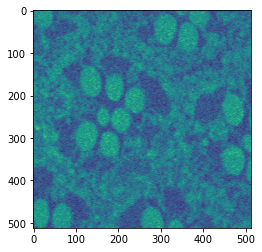

In [13]:
imshow(new_imgs[0])

In [14]:
imgs_train = new_imgs[0:150]
imgs_mask_train = new_labels[0:150]
imgs_test = new_imgs[150:]
imgs_mask_test = new_labels[150:]

In [15]:
#general
import os
import zipfile
import io
import glob
import numpy as np
import matplotlib.pyplot as plt
import time
from datetime import datetime

#ml and imaging
from scipy import misc
from sklearn.metrics import auc
from sklearn.metrics import precision_recall_curve
from scipy.ndimage.filters import median_filter
import cv2
import mahotas as mh
from keras.models import *
from keras.layers import Input, merge, Conv2D, MaxPooling2D, UpSampling2D, Dropout, Cropping2D
from keras.optimizers import *
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras import backend as K
from keras import backend as keras
import keras.callbacks
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

#helper
import tqdm
from tqdm import tqdm
from IPython.display import clear_output
import warnings
warnings.filterwarnings('ignore')
MEMORY = 1

In [16]:
def keras_dice_coef(y_true, y_pred, smooth=10): #0.01
    '''Average dice coefficient per batch.'''
    axes = (1,2,3)
    intersection = K.sum(y_true * y_pred, axis=axes)
    summation = K.sum(y_true, axis=axes) + K.sum(y_pred, axis=axes)
    return K.mean((2.0 * intersection + smooth) / (summation + smooth), axis=0)

def keras_jaccard_coef(y_true, y_pred, smooth=0.01):
    '''Average jaccard coefficient per batch.'''
    axes = (1,2,3)
    intersection = K.sum(y_true * y_pred, axis=axes)
    union = K.sum(y_true, axis=axes) + K.sum(y_pred, axis=axes) - intersection
    return K.mean( (intersection + smooth) / (union + smooth), axis=0)

def keras_precision(y_true, y_pred):
    """Precision metric.
    Only computes a batch-wise average of precision.
    Computes the precision, a metric for multi-label classification of
    how many selected items are relevant.
    """
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def keras_recall(y_true, y_pred):
    """Recall metric.
    Only computes a batch-wise average of recall.
    Computes the recall, a metric for multi-label classification of
    how many relevant items are selected.
    """
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def keras_jaccard_distance_loss(y_true, y_pred, smooth=0.01): #avg jaccard index on batch
    '''Average jaccard coefficient per batch.'''
    axes = (1,2,3)
    intersection = K.sum(y_true * y_pred, axis=axes)
    union = K.sum(y_true, axis=axes) + K.sum(y_pred, axis=axes) - intersection
    return 1-K.mean( (intersection + smooth) / (union + smooth), axis=0)

def keras_focal_loss(target, output, gamma=2):
    output /= K.sum(output, axis=-1, keepdims=True)
    eps = K.epsilon()
    output = K.clip(output, eps, 1. - eps)
    return -K.sum(K.pow(1. - output, gamma) * target * K.log(output), axis=-1)

def keras_dice_coef_loss(y_true, y_pred):
    return 1.0 - dice_coef(y_true, y_pred, smooth=10.0)

def keras_binary_crossentropy_mod(y_true, y_pred):
    raw_prediction=K.reshape(y_pred,[-1])
    gt = K.reshape(y_true, [-1])
    #supposed 2 is the ignored label
    
    indices = K.squeeze(K.tf.where(K.not_equal(gt,2)),1)
    
    gt = K.cast(K.gather(gt,indices), 'float32')
    prediction = K.gather(raw_prediction,indices)
    return K.mean(K.binary_crossentropy(gt, prediction), axis=-1)

In [17]:
class InteractivePlot(keras.callbacks.Callback):
    def __init__(self, logfile, doplot, num_batches):
        self.logfile = logfile
        self.doplot = doplot
        self.f = open(logfile, 'a', 1)
        self.num_batches = num_batches

    def on_train_begin(self, logs={}):
        print("starting...")
        self.losses = []
        self.acc = []
        self.prec = []
        self.rec = []
        self.jaccard = []
        self.dice = []

        self.losses_val = []
        self.acc_val = []
        self.prec_val = []
        self.rec_val = []
        self.jaccard_val = []
        self.dice_val = []

        self.batchnr = 0
        self.time_epoch = []
        self.timestamp = time.time()
        self.icount = 0

        self.logs = []

    def on_train_end(self, logs={}):
        self.f.close()
        print('training ended, logfile closed.')

    def on_epoch_end(self, epoch, logs={}):
        self.batchnr = 0
        elapsed = time.time() - self.timestamp
        self.timestamp = time.time()
        self.time_epoch.append(elapsed)

        loss_train = logs.get('loss')
        acc_train = logs.get('acc')
        prec = logs.get('keras_precision')
        recall = logs.get('keras_recall')
        jaccard = logs.get('keras_jaccard_coef')
        dice = logs.get('keras_dice_coef')

        loss_val = logs.get('val_loss')
        acc_val = logs.get('val_acc')
        prec_val = logs.get('val_keras_precision')
        recall_val = logs.get('val_keras_recall')
        jaccard_val = logs.get('val_keras_jaccard_coef')
        dice_val = logs.get('val_keras_dice_coef')


        self.losses.append(loss_train)
        self.acc.append(acc_train)
        self.prec.append(prec)
        self.rec.append(recall)
        self.jaccard.append(jaccard)
        self.dice.append(dice)

        self.losses_val.append(loss_val)
        self.acc_val.append(acc_val)
        self.prec_val.append(prec_val)
        self.rec_val.append(recall_val)
        self.jaccard_val.append(jaccard_val)
        self.dice_val.append(dice_val)

        self.icount+=1        

        if self.doplot:
            clear_output(wait=True)
            plt.figure(figsize=(14,10))
            train_vals = [self.losses, self.acc, self.prec, self.rec, self.jaccard, self.dice]
            test_vals = [self.losses_val, self.acc_val, self.prec_val, self.rec_val, self.jaccard_val, self.dice_val]
            desc = ['loss', 'accuracy', 'precision', 'recall', 'jaccard', 'dice']
            for i in range(len(train_vals)):
                plt.subplot(2, 3, i+1)
                plt.plot(range(self.icount), train_vals[i], label=desc[i])
                plt.plot(range(self.icount), test_vals[i], label="val_" + desc[i])
                plt.ylim(0,1)
                plt.legend()
            plt.savefig(self.logfile.replace('.txt', '.png'), bbox_inches='tight', format='png')   
            plt.show()

        else:
            clear_output(wait=True)

        print('iteration', self.icount)
        print('loss', loss_train, 'loss_val', loss_val)
        print('acc', acc_train, 'acc_val', acc_val)
        print('prec', prec, 'prec_val', prec_val)
        print('rec', recall, 'rec_val', recall_val)
        print('jaccard', jaccard, 'jaccard_val', jaccard_val)
        print('dice', dice, 'dice_val', dice_val)
        print('time per epoch:', np.array(self.time_epoch).mean())
        self.f.write('iteration=' + str(self.icount) + '|loss_val=' + str(loss_val) + '|acc_val=' + str(acc_val) + '|prec_val=' + str(prec_val) + '|rec_val=' + str(recall_val) + '|jaccard_val=' + str(jaccard_val) + '|dice_val=' + str(dice_val) + '|loss=' + str(loss_train) + '|acc=' + str(acc_train) + '|prec=' + str(prec) + '|rec=' + str(recall) + '|jaccard=' + str(jaccard) + '|dice=' + str(dice) + '|time=' + str(elapsed) + '\n')

    def on_batch_end(self, batch, logs=None):  
        self.batchnr+=1
        if self.batchnr%10==0:
            print('batch', self.batchnr, 'of', self.num_batches, '...')

In [18]:
def load_data(raw_path, mask_path):
    numimages = 0
    for j in range(len(raw_path)):
        input_dir = raw_path[j]
        files_raw = sorted(glob.glob(input_dir + '/*.png'))
        print('found', len(files_raw), 'images in', input_dir)
        numimages+=len(files_raw)
    print('found', numimages, 'in total.')

    imgdatas = np.ndarray((numimages,768,1024,1), dtype=np.float32)
    imglabels = np.ndarray((numimages,768,1024,1), dtype=np.float32)
    global_ct = 0
    for j in tqdm(range(len(raw_path))):
        input_dir = raw_path[j]
        input_dir_mask = mask_path[j]
        files_raw = sorted(glob.glob(input_dir + '/*.png'))
        files_mask = sorted(glob.glob(input_dir_mask + '/*.png'))

        for i in range(len(files_raw)):
            file_raw = files_raw[i]
            file_mask = files_mask[i]
            img = load_img(file_raw,grayscale = True)
            label = load_img(file_mask,grayscale = True)
            img = img_to_array(img)
            label = img_to_array(label)
            imgdatas[global_ct] = img/255.
            imglabels[global_ct] = label/255.
            global_ct+=1
    print(imgdatas.shape)
    print(imglabels.shape)
    return imgdatas, imglabels

def rotate_bound(image, angle, mode, fill_black=True):
    big_stack = []
    for img_index in range(image.shape[2]):
        # grab the dimensions of the image and then determine the center
        (h, w) = image.shape[:2]
        (cX, cY) = (w // 2, h // 2)

        # grab the rotation matrix (applying the negative of the
        # angle to rotate clockwise), then grab the sine and cosine
        # (i.e., the rotation components of the matrix)
        M = cv2.getRotationMatrix2D((cX, cY), -angle, 1.0)
        cos = np.abs(M[0, 0])
        sin = np.abs(M[0, 1])

        # compute the new bounding dimensions of the image
        nW = int((h * sin) + (w * cos))
        nH = int((h * cos) + (w * sin))

        # adjust the rotation matrix to take into account translation
        M[0, 2] += (nW / 2) - cX
        M[1, 2] += (nH / 2) - cY
 
        if fill_black:
            bt = (0,0,255)
        else:
            bt = 2
        big_stack.append(cv2.warpAffine(image[:,:,img_index], M, (nW, nH), flags=mode, borderMode=cv2.BORDER_CONSTANT, borderValue=bt)) 
    big_stack = np.array(big_stack)
    big_stack = np.swapaxes(big_stack,0,1)
    big_stack = np.swapaxes(big_stack,1,2)
    return big_stack
        
def custom_preproc(img_in, mode, flip_z=False, rotate=False, mean=None, sd=None, fill_black=True, train_on_borders=False):
    #input is (768, 1024, d)
    if flip_z:
        if np.random.rand()<0.5:
            img_in = np.flip(img_in, 2)

    if not mean is None:
        img_in = img_in-mean
    if not sd is None:
        sd[sd==0]=1e-4
        img_in = img_in/sd

    m = None
    if mode=='raw':
        m = cv2.INTER_LINEAR
    elif mode=='mask':
        m = cv2.INTER_NEAREST 
   
    if rotate:
        img_in = rotate_bound(img_in, np.random.rand()*360, m, fill_black = fill_black)
        img_in = img_in.reshape(img_in.shape[0], img_in.shape[1], img_in.shape[2])

    MIN_SIZE = 512
    MAX_SIZE = max(MIN_SIZE+1,min(img_in.shape[0], img_in.shape[1]))
    size = np.random.randint(MIN_SIZE, MAX_SIZE)
    width = img_in.shape[0]
    height = img_in.shape[1]

    xposs = max(1,width-size)
    yposs = max(1,height-size)

    xcrop = np.random.randint(0,xposs)
    ycrop = np.random.randint(0,yposs)
    crop = img_in[xcrop:(xcrop+size), ycrop:(ycrop+size), :]
    
    #upsampling if necessary
    if crop.shape[0]==512 and crop.shape[1]==512:
        if mode=='mask':
            crop[(crop>0) & (crop<1.5)] = 1 
        
        if train_on_borders and mode=='mask':
            crop = mh.borders(crop).astype(int)
        return crop
    else: #upsampling
        big_stack = np.zeros((512,512,crop.shape[2]))
        for imgindex in range(crop.shape[2]):
            ref = cv2.resize(crop[:,:,imgindex], (512,512), interpolation=m)
            big_stack[:,:,imgindex] = ref
        
        if mode=='mask':
            big_stack[(big_stack>0) & (big_stack<1.5)]=1
            if train_on_borders:
                big_stack = mh.borders(big_stack).astype(int)
        return big_stack

def load_stack(imgdir, alphanum=False):
    files = list(sorted(glob.glob(os.path.join(imgdir, '*.png'))))
    st = []
    for i in tqdm(range(len(files))):
        ff = imgdir + '/' + str(i) + '.png' 
        if not alphanum: ff=files[i]
        input_img = misc.imread(ff)
        if len(input_img.shape)>2: input_img = input_img[:,:,0]
        input_img = input_img.astype(float)/255.
        testinp = input_img.reshape(input_img.shape[0],input_img.shape[1], 1)
        st.append(testinp)
    return np.array(st)

In [19]:
"""Fairly basic set of tools for real-time data augmentation on image data.
Can easily be extended to include new transformations,
new preprocessing methods, etc...
"""
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import numpy as np
import re
from scipy import linalg
import scipy.ndimage as ndi
from six.moves import range
import os
import threading
import warnings
import multiprocessing.pool
from functools import partial

from keras import backend as K
from keras.utils.data_utils import Sequence

try:
    from PIL import ImageEnhance
    from PIL import Image as pil_image
except ImportError:
    pil_image = None

if pil_image is not None:
    _PIL_INTERPOLATION_METHODS = {
        'nearest': pil_image.NEAREST,
        'bilinear': pil_image.BILINEAR,
        'bicubic': pil_image.BICUBIC,
    }
    # These methods were only introduced in version 3.4.0 (2016).
    if hasattr(pil_image, 'HAMMING'):
        _PIL_INTERPOLATION_METHODS['hamming'] = pil_image.HAMMING
    if hasattr(pil_image, 'BOX'):
        _PIL_INTERPOLATION_METHODS['box'] = pil_image.BOX
    # This method is new in version 1.1.3 (2013).
    if hasattr(pil_image, 'LANCZOS'):
        _PIL_INTERPOLATION_METHODS['lanczos'] = pil_image.LANCZOS


def random_rotation(x, rg, row_axis=1, col_axis=2, channel_axis=0,
                    fill_mode='nearest', cval=0.):
    """Performs a random rotation of a Numpy image tensor.
    # Arguments
        x: Input tensor. Must be 3D.
        rg: Rotation range, in degrees.
        row_axis: Index of axis for rows in the input tensor.
        col_axis: Index of axis for columns in the input tensor.
        channel_axis: Index of axis for channels in the input tensor.
        fill_mode: Points outside the boundaries of the input
            are filled according to the given mode
            (one of `{'constant', 'nearest', 'reflect', 'wrap'}`).
        cval: Value used for points outside the boundaries
            of the input if `mode='constant'`.
    # Returns
        Rotated Numpy image tensor.
    """
    theta = np.deg2rad(np.random.uniform(-rg, rg))
    rotation_matrix = np.array([[np.cos(theta), -np.sin(theta), 0],
                                [np.sin(theta), np.cos(theta), 0],
                                [0, 0, 1]])

    h, w = x.shape[row_axis], x.shape[col_axis]
    transform_matrix = transform_matrix_offset_center(rotation_matrix, h, w)
    x = apply_transform(x, transform_matrix, channel_axis, fill_mode, cval)
    return x


def random_shift(x, wrg, hrg, row_axis=1, col_axis=2, channel_axis=0,
                 fill_mode='nearest', cval=0.):
    """Performs a random spatial shift of a Numpy image tensor.
    # Arguments
        x: Input tensor. Must be 3D.
        wrg: Width shift range, as a float fraction of the width.
        hrg: Height shift range, as a float fraction of the height.
        row_axis: Index of axis for rows in the input tensor.
        col_axis: Index of axis for columns in the input tensor.
        channel_axis: Index of axis for channels in the input tensor.
        fill_mode: Points outside the boundaries of the input
            are filled according to the given mode
            (one of `{'constant', 'nearest', 'reflect', 'wrap'}`).
        cval: Value used for points outside the boundaries
            of the input if `mode='constant'`.
    # Returns
        Shifted Numpy image tensor.
    """
    h, w = x.shape[row_axis], x.shape[col_axis]
    tx = np.random.uniform(-hrg, hrg) * h
    ty = np.random.uniform(-wrg, wrg) * w
    translation_matrix = np.array([[1, 0, tx],
                                   [0, 1, ty],
                                   [0, 0, 1]])

    transform_matrix = translation_matrix  # no need to do offset
    x = apply_transform(x, transform_matrix, channel_axis, fill_mode, cval)
    return x


def random_shear(x, intensity, row_axis=1, col_axis=2, channel_axis=0,
                 fill_mode='nearest', cval=0.):
    """Performs a random spatial shear of a Numpy image tensor.
    # Arguments
        x: Input tensor. Must be 3D.
        intensity: Transformation intensity in degrees.
        row_axis: Index of axis for rows in the input tensor.
        col_axis: Index of axis for columns in the input tensor.
        channel_axis: Index of axis for channels in the input tensor.
        fill_mode: Points outside the boundaries of the input
            are filled according to the given mode
            (one of `{'constant', 'nearest', 'reflect', 'wrap'}`).
        cval: Value used for points outside the boundaries
            of the input if `mode='constant'`.
    # Returns
        Sheared Numpy image tensor.
    """
    shear = np.deg2rad(np.random.uniform(-intensity, intensity))
    shear_matrix = np.array([[1, -np.sin(shear), 0],
                             [0, np.cos(shear), 0],
                             [0, 0, 1]])

    h, w = x.shape[row_axis], x.shape[col_axis]
    transform_matrix = transform_matrix_offset_center(shear_matrix, h, w)
    x = apply_transform(x, transform_matrix, channel_axis, fill_mode, cval)
    return x


def random_zoom(x, zoom_range, row_axis=1, col_axis=2, channel_axis=0,
                fill_mode='nearest', cval=0.):
    """Performs a random spatial zoom of a Numpy image tensor.
    # Arguments
        x: Input tensor. Must be 3D.
        zoom_range: Tuple of floats; zoom range for width and height.
        row_axis: Index of axis for rows in the input tensor.
        col_axis: Index of axis for columns in the input tensor.
        channel_axis: Index of axis for channels in the input tensor.
        fill_mode: Points outside the boundaries of the input
            are filled according to the given mode
            (one of `{'constant', 'nearest', 'reflect', 'wrap'}`).
        cval: Value used for points outside the boundaries
            of the input if `mode='constant'`.
    # Returns
        Zoomed Numpy image tensor.
    # Raises
        ValueError: if `zoom_range` isn't a tuple.
    """
    if len(zoom_range) != 2:
        raise ValueError('`zoom_range` should be a tuple or list of two floats. '
                         'Received arg: ', zoom_range)

    if zoom_range[0] == 1 and zoom_range[1] == 1:
        zx, zy = 1, 1
    else:
        zx, zy = np.random.uniform(zoom_range[0], zoom_range[1], 2)
    zoom_matrix = np.array([[zx, 0, 0],
                            [0, zy, 0],
                            [0, 0, 1]])

    h, w = x.shape[row_axis], x.shape[col_axis]
    transform_matrix = transform_matrix_offset_center(zoom_matrix, h, w)
    x = apply_transform(x, transform_matrix, channel_axis, fill_mode, cval)
    return x


def random_channel_shift(x, intensity, channel_axis=0):
    """Perform a random channel shift.
    # Arguments
        x: Input tensor. Must be 3D.
        intensity: Transformation intensity.
        channel_axis: Index of axis for channels in the input tensor.
    # Returns
        Numpy image tensor.
    """
    x = np.rollaxis(x, channel_axis, 0)
    min_x, max_x = np.min(x), np.max(x)
    channel_images = [np.clip(x_channel + np.random.uniform(-intensity, intensity), min_x, max_x)
                      for x_channel in x]
    x = np.stack(channel_images, axis=0)
    x = np.rollaxis(x, 0, channel_axis + 1)
    return x


def random_brightness(x, brightness_range):
    """Perform a random brightness shift.
    # Arguments
        x: Input tensor. Must be 3D.
        brightness_range: Tuple of floats; brightness range.
        channel_axis: Index of axis for channels in the input tensor.
    # Returns
        Numpy image tensor.
    # Raises
        ValueError if `brightness_range` isn't a tuple.
    """
    if len(brightness_range) != 2:
        raise ValueError('`brightness_range should be tuple or list of two floats. '
                         'Received arg: ', brightness_range)

    x = array_to_img(x)
    x = imgenhancer_Brightness = ImageEnhance.Brightness(x)
    u = np.random.uniform(brightness_range[0], brightness_range[1])
    x = imgenhancer_Brightness.enhance(u)
    x = img_to_array(x)
    return x


def transform_matrix_offset_center(matrix, x, y):
    o_x = float(x) / 2 + 0.5
    o_y = float(y) / 2 + 0.5
    offset_matrix = np.array([[1, 0, o_x], [0, 1, o_y], [0, 0, 1]])
    reset_matrix = np.array([[1, 0, -o_x], [0, 1, -o_y], [0, 0, 1]])
    transform_matrix = np.dot(np.dot(offset_matrix, matrix), reset_matrix)
    return transform_matrix


def apply_transform(x,
                    transform_matrix,
                    channel_axis=0,
                    fill_mode='nearest',
                    cval=0.):
    """Apply the image transformation specified by a matrix.
    # Arguments
        x: 2D numpy array, single image.
        transform_matrix: Numpy array specifying the geometric transformation.
        channel_axis: Index of axis for channels in the input tensor.
        fill_mode: Points outside the boundaries of the input
            are filled according to the given mode
            (one of `{'constant', 'nearest', 'reflect', 'wrap'}`).
        cval: Value used for points outside the boundaries
            of the input if `mode='constant'`.
    # Returns
        The transformed version of the input.
    """
    x = np.rollaxis(x, channel_axis, 0)
    final_affine_matrix = transform_matrix[:2, :2]
    final_offset = transform_matrix[:2, 2]
    channel_images = [ndi.interpolation.affine_transform(
        x_channel,
        final_affine_matrix,
        final_offset,
        order=1,
        mode=fill_mode,
        cval=cval) for x_channel in x]
    x = np.stack(channel_images, axis=0)
    x = np.rollaxis(x, 0, channel_axis + 1)
    return x


def flip_axis(x, axis):
    x = np.asarray(x).swapaxes(axis, 0)
    x = x[::-1, ...]
    x = x.swapaxes(0, axis)
    return x


def array_to_img(x, data_format=None, scale=True):
    """Converts a 3D Numpy array to a PIL Image instance.
    # Arguments
        x: Input Numpy array.
        data_format: Image data format.
        scale: Whether to rescale image values
            to be within [0, 255].
    # Returns
        A PIL Image instance.
    # Raises
        ImportError: if PIL is not available.
        ValueError: if invalid `x` or `data_format` is passed.
    """
    if pil_image is None:
        raise ImportError('Could not import PIL.Image. '
                          'The use of `array_to_img` requires PIL.')
    x = np.asarray(x, dtype=K.floatx())
    if x.ndim != 3:
        raise ValueError('Expected image array to have rank 3 (single image). '
                         'Got array with shape:', x.shape)

    if data_format is None:
        data_format = K.image_data_format()
    if data_format not in {'channels_first', 'channels_last'}:
        raise ValueError('Invalid data_format:', data_format)

    # Original Numpy array x has format (height, width, channel)
    # or (channel, height, width)
    # but target PIL image has format (width, height, channel)
    if data_format == 'channels_first':
        x = x.transpose(1, 2, 0)
    if scale:
        x = x + max(-np.min(x), 0)
        x_max = np.max(x)
        if x_max != 0:
            x /= x_max
        x *= 255
    if x.shape[2] == 3:
        # RGB
        return pil_image.fromarray(x.astype('uint8'), 'RGB')
    elif x.shape[2] == 1:
        # grayscale
        return pil_image.fromarray(x[:, :, 0].astype('uint8'), 'L')
    else:
        raise ValueError('Unsupported channel number: ', x.shape[2])


def img_to_array(img, data_format=None):
    """Converts a PIL Image instance to a Numpy array.
    # Arguments
        img: PIL Image instance.
        data_format: Image data format.
    # Returns
        A 3D Numpy array.
    # Raises
        ValueError: if invalid `img` or `data_format` is passed.
    """
    if data_format is None:
        data_format = K.image_data_format()
    if data_format not in {'channels_first', 'channels_last'}:
        raise ValueError('Unknown data_format: ', data_format)
    # Numpy array x has format (height, width, channel)
    # or (channel, height, width)
    # but original PIL image has format (width, height, channel)
    x = np.asarray(img, dtype=K.floatx())
    if len(x.shape) == 3:
        if data_format == 'channels_first':
            x = x.transpose(2, 0, 1)
    elif len(x.shape) == 2:
        if data_format == 'channels_first':
            x = x.reshape((1, x.shape[0], x.shape[1]))
        else:
            x = x.reshape((x.shape[0], x.shape[1], 1))
    else:
        raise ValueError('Unsupported image shape: ', x.shape)
    return x


def load_img(path, grayscale=False, target_size=None,
             interpolation='nearest'):
    """Loads an image into PIL format.
    # Arguments
        path: Path to image file
        grayscale: Boolean, whether to load the image as grayscale.
        target_size: Either `None` (default to original size)
            or tuple of ints `(img_height, img_width)`.
        interpolation: Interpolation method used to resample the image if the
            target size is different from that of the loaded image.
            Supported methods are "nearest", "bilinear", and "bicubic".
            If PIL version 1.1.3 or newer is installed, "lanczos" is also
            supported. If PIL version 3.4.0 or newer is installed, "box" and
            "hamming" are also supported. By default, "nearest" is used.
    # Returns
        A PIL Image instance.
    # Raises
        ImportError: if PIL is not available.
        ValueError: if interpolation method is not supported.
    """
    if pil_image is None:
        raise ImportError('Could not import PIL.Image. '
                          'The use of `array_to_img` requires PIL.')
    img = pil_image.open(path)
    if grayscale:
        if img.mode != 'L':
            img = img.convert('L')
    else:
        if img.mode != 'RGB':
            img = img.convert('RGB')
    if target_size is not None:
        width_height_tuple = (target_size[1], target_size[0])
        if img.size != width_height_tuple:
            if interpolation not in _PIL_INTERPOLATION_METHODS:
                raise ValueError(
                    'Invalid interpolation method {} specified. Supported '
                    'methods are {}'.format(
                        interpolation,
                        ", ".join(_PIL_INTERPOLATION_METHODS.keys())))
            resample = _PIL_INTERPOLATION_METHODS[interpolation]
            img = img.resize(width_height_tuple, resample)
    return img


def list_pictures(directory, ext='jpg|jpeg|bmp|png|ppm'):
    return [os.path.join(root, f)
            for root, _, files in os.walk(directory) for f in files
            if re.match(r'([\w]+\.(?:' + ext + '))', f)]


class ExtImageDataGenerator(object):
    """Generate batches of tensor image data with real-time data augmentation.
     The data will be looped over (in batches).
    # Arguments
        featurewise_center: Boolean. Set input mean to 0 over the dataset, feature-wise.
        samplewise_center: Boolean. Set each sample mean to 0.
        featurewise_std_normalization: Boolean. Divide inputs by std of the dataset, feature-wise.
        samplewise_std_normalization: Boolean. Divide each input by its std.
        zca_epsilon: epsilon for ZCA whitening. Default is 1e-6.
        zca_whitening: Boolean. Apply ZCA whitening.
        rotation_range: Int. Degree range for random rotations.
        width_shift_range: float, 1-D array-like or int
            float: fraction of total width, if < 1, or pixels if >= 1.
            1-D array-like: random elements from the array.
            int: integer number of pixels from interval
                `(-width_shift_range, +width_shift_range)`
            With `width_shift_range=2` possible values are integers [-1, 0, +1],
            same as with `width_shift_range=[-1, 0, +1]`,
            while with `width_shift_range=1.0` possible values are floats in
            the interval [-1.0, +1.0).
        shear_range: Float. Shear Intensity (Shear angle in counter-clockwise direction in degrees)
        zoom_range: Float or [lower, upper]. Range for random zoom. If a float, `[lower, upper] = [1-zoom_range, 1+zoom_range]`.
        channel_shift_range: Float. Range for random channel shifts.
        fill_mode: One of {"constant", "nearest", "reflect" or "wrap"}.  Default is 'nearest'.
        Points outside the boundaries of the input are filled according to the given mode:
            'constant': kkkkkkkk|abcd|kkkkkkkk (cval=k)
            'nearest':  aaaaaaaa|abcd|dddddddd
            'reflect':  abcddcba|abcd|dcbaabcd
            'wrap':  abcdabcd|abcd|abcdabcd
        cval: Float or Int. Value used for points outside the boundaries when `fill_mode = "constant"`.
        horizontal_flip: Boolean. Randomly flip inputs horizontally.
        vertical_flip: Boolean. Randomly flip inputs vertically.
        rescale: rescaling factor. Defaults to None. If None or 0, no rescaling is applied,
                otherwise we multiply the data by the value provided (before applying
                any other transformation).
        preprocessing_function: function that will be implied on each input.
                The function will run after the image is resized and augmented.
                The function should take one argument:
                one image (Numpy tensor with rank 3),
                and should output a Numpy tensor with the same shape.
        data_format: One of {"channels_first", "channels_last"}.
            "channels_last" mode means that the images should have shape `(samples, height, width, channels)`,
            "channels_first" mode means that the images should have shape `(samples, channels, height, width)`.
            It defaults to the `image_data_format` value found in your
            Keras config file at `~/.keras/keras.json`.
            If you never set it, then it will be "channels_last".
        validation_split: Float. Fraction of images reserved for validation (strictly between 0 and 1).
    # Examples
    Example of using `.flow(x, y)`:
    ```python
    (x_train, y_train), (x_test, y_test) = cifar10.load_data()
    y_train = np_utils.to_categorical(y_train, num_classes)
    y_test = np_utils.to_categorical(y_test, num_classes)
    datagen = ImageDataGenerator(
        featurewise_center=True,
        featurewise_std_normalization=True,
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        horizontal_flip=True)
    # compute quantities required for featurewise normalization
    # (std, mean, and principal components if ZCA whitening is applied)
    datagen.fit(x_train)
    # fits the model on batches with real-time data augmentation:
    model.fit_generator(datagen.flow(x_train, y_train, batch_size=32),
                        steps_per_epoch=len(x_train) / 32, epochs=epochs)
    # here's a more "manual" example
    for e in range(epochs):
        print('Epoch', e)
        batches = 0
        for x_batch, y_batch in datagen.flow(x_train, y_train, batch_size=32):
            model.fit(x_batch, y_batch)
            batches += 1
            if batches >= len(x_train) / 32:
                # we need to break the loop by hand because
                # the generator loops indefinitely
                break
    ```
    Example of using `.flow_from_directory(directory)`:
    ```python
    train_datagen = ImageDataGenerator(
            rescale=1./255,
            shear_range=0.2,
            zoom_range=0.2,
            horizontal_flip=True)
    test_datagen = ImageDataGenerator(rescale=1./255)
    train_generator = train_datagen.flow_from_directory(
            'data/train',
            target_size=(150, 150),
            batch_size=32,
            class_mode='binary')
    validation_generator = test_datagen.flow_from_directory(
            'data/validation',
            target_size=(150, 150),
            batch_size=32,
            class_mode='binary')
    model.fit_generator(
            train_generator,
            steps_per_epoch=2000,
            epochs=50,
            validation_data=validation_generator,
            validation_steps=800)
    ```
    Example of transforming images and masks together.
    ```python
    # we create two instances with the same arguments
    data_gen_args = dict(featurewise_center=True,
                         featurewise_std_normalization=True,
                         rotation_range=90.,
                         width_shift_range=0.1,
                         height_shift_range=0.1,
                         zoom_range=0.2)
    image_datagen = ImageDataGenerator(**data_gen_args)
    mask_datagen = ImageDataGenerator(**data_gen_args)
    # Provide the same seed and keyword arguments to the fit and flow methods
    seed = 1
    image_datagen.fit(images, augment=True, seed=seed)
    mask_datagen.fit(masks, augment=True, seed=seed)
    image_generator = image_datagen.flow_from_directory(
        'data/images',
        class_mode=None,
        seed=seed)
    mask_generator = mask_datagen.flow_from_directory(
        'data/masks',
        class_mode=None,
        seed=seed)
    # combine generators into one which yields image and masks
    train_generator = zip(image_generator, mask_generator)
    model.fit_generator(
        train_generator,
        steps_per_epoch=2000,
        epochs=50)
    ```
    """

    def __init__(self,
                 num_channels=1,
                 featurewise_center=False,
                 samplewise_center=False,
                 featurewise_std_normalization=False,
                 samplewise_std_normalization=False,
                 zca_whitening=False,
                 zca_epsilon=1e-6,
                 rotation_range=0.,
                 width_shift_range=0.,
                 height_shift_range=0.,
                 brightness_range=None,
                 shear_range=0.,
                 zoom_range=0.,
                 channel_shift_range=0.,
                 fill_mode='nearest',
                 cval=0.,
                 horizontal_flip=False,
                 vertical_flip=False,
                 rescale=None,
                 preprocessing_function=None,
                 data_format=None,
                 validation_split=0.0):
        if data_format is None:
            data_format = K.image_data_format()
        self.num_channels = num_channels
        self.featurewise_center = featurewise_center
        self.samplewise_center = samplewise_center
        self.featurewise_std_normalization = featurewise_std_normalization
        self.samplewise_std_normalization = samplewise_std_normalization
        self.zca_whitening = zca_whitening
        self.zca_epsilon = zca_epsilon
        self.rotation_range = rotation_range
        self.width_shift_range = width_shift_range
        self.height_shift_range = height_shift_range
        self.brightness_range = brightness_range
        self.shear_range = shear_range
        self.zoom_range = zoom_range
        self.channel_shift_range = channel_shift_range
        self.fill_mode = fill_mode
        self.cval = cval
        self.horizontal_flip = horizontal_flip
        self.vertical_flip = vertical_flip
        self.rescale = rescale
        self.preprocessing_function = preprocessing_function

        if data_format not in {'channels_last', 'channels_first'}:
            raise ValueError('`data_format` should be `"channels_last"` (channel after row and '
                             'column) or `"channels_first"` (channel before row and column). '
                             'Received arg: ', data_format)
        self.data_format = data_format
        if data_format == 'channels_first':
            self.channel_axis = 1
            self.row_axis = 2
            self.col_axis = 3
        if data_format == 'channels_last':
            self.channel_axis = 3
            self.row_axis = 1
            self.col_axis = 2
        if validation_split and not 0 < validation_split < 1:
            raise ValueError('`validation_split` must be strictly between 0 and 1. '
                             ' Received arg: ', validation_split)
        self._validation_split = validation_split

        self.mean = None
        self.std = None
        self.principal_components = None

        if np.isscalar(zoom_range):
            self.zoom_range = [1 - zoom_range, 1 + zoom_range]
        elif len(zoom_range) == 2:
            self.zoom_range = [zoom_range[0], zoom_range[1]]
        else:
            raise ValueError('`zoom_range` should be a float or '
                             'a tuple or list of two floats. '
                             'Received arg: ', zoom_range)
        if zca_whitening:
            if not featurewise_center:
                self.featurewise_center = True
                warnings.warn('This ImageDataGenerator specifies '
                              '`zca_whitening`, which overrides '
                              'setting of `featurewise_center`.')
            if featurewise_std_normalization:
                self.featurewise_std_normalization = False
                warnings.warn('This ImageDataGenerator specifies '
                              '`zca_whitening` '
                              'which overrides setting of'
                              '`featurewise_std_normalization`.')
        if featurewise_std_normalization:
            if not featurewise_center:
                self.featurewise_center = True
                warnings.warn('This ImageDataGenerator specifies '
                              '`featurewise_std_normalization`, '
                              'which overrides setting of '
                              '`featurewise_center`.')
        if samplewise_std_normalization:
            if not samplewise_center:
                self.samplewise_center = True
                warnings.warn('This ImageDataGenerator specifies '
                              '`samplewise_std_normalization`, '
                              'which overrides setting of '
                              '`samplewise_center`.')

    def flow(self, x, y=None, batch_size=32, shuffle=True, seed=None,
             save_to_dir=None, save_prefix='', save_format='png', subset=None):
        """Takes numpy data & label arrays, and generates batches of
            augmented/normalized data.
        # Arguments
               x: data. Should have rank 4.
                In case of grayscale data,
                the channels axis should have value 1, and in case
                of RGB data, it should have value 3.
               y: labels.
               batch_size: int (default: 32).
               shuffle: boolean (default: True).
               seed: int (default: None).
               save_to_dir: None or str (default: None).
                This allows you to optionally specify a directory
                to which to save the augmented pictures being generated
                (useful for visualizing what you are doing).
               save_prefix: str (default: `''`). Prefix to use for filenames of saved pictures
                (only relevant if `save_to_dir` is set).
                save_format: one of "png", "jpeg" (only relevant if `save_to_dir` is set). Default: "png".
               subset: Subset of data (`"training"` or `"validation"`) if
                `validation_split` is set in `ImageDataGenerator`.
        # Returns
            An Iterator yielding tuples of `(x, y)` where `x` is a numpy array of image data and
             `y` is a numpy array of corresponding labels."""
        return NumpyArrayIterator(
            x, y, self.num_channels, self,
            batch_size=batch_size,
            shuffle=shuffle,
            seed=seed,
            data_format=self.data_format,
            save_to_dir=save_to_dir,
            save_prefix=save_prefix,
            save_format=save_format,
            subset=subset)

    def flow_from_directory(self, directory,
                            target_size=(256, 256), color_mode='rgb',
                            classes=None, class_mode='categorical',
                            batch_size=32, shuffle=True, seed=None,
                            save_to_dir=None,
                            save_prefix='',
                            save_format='png',
                            follow_links=False,
                            subset=None,
                            interpolation='nearest'):
        """Takes the path to a directory, and generates batches of augmented/normalized data.
        # Arguments
                directory: path to the target directory.
                 It should contain one subdirectory per class.
                 Any PNG, JPG, BMP, PPM or TIF images inside each of the subdirectories directory tree will be included in the generator.
                See [this script](https://gist.github.com/fchollet/0830affa1f7f19fd47b06d4cf89ed44d) for more details.
                target_size: tuple of integers `(height, width)`, default: `(256, 256)`.
                 The dimensions to which all images found will be resized.
                color_mode: one of "grayscale", "rbg". Default: "rgb".
                 Whether the images will be converted to have 1 or 3 color channels.
                classes: optional list of class subdirectories (e.g. `['dogs', 'cats']`). Default: None.
                 If not provided, the list of classes will be automatically
                 inferred from the subdirectory names/structure under `directory`,
                 where each subdirectory will be treated as a different class
                 (and the order of the classes, which will map to the label indices, will be alphanumeric).
                 The dictionary containing the mapping from class names to class
                 indices can be obtained via the attribute `class_indices`.
                class_mode: one of "categorical", "binary", "sparse", "input" or None. Default: "categorical".
                 Determines the type of label arrays that are returned: "categorical" will be 2D one-hot encoded labels,
                 "binary" will be 1D binary labels, "sparse" will be 1D integer labels, "input" will be images identical
                 to input images (mainly used to work with autoencoders).
                 If None, no labels are returned (the generator will only yield batches of image data, which is useful to use
                 `model.predict_generator()`, `model.evaluate_generator()`, etc.).
                  Please note that in case of class_mode None,
                   the data still needs to reside in a subdirectory of `directory` for it to work correctly.
                batch_size: size of the batches of data (default: 32).
                shuffle: whether to shuffle the data (default: True)
                seed: optional random seed for shuffling and transformations.
                save_to_dir: None or str (default: None). This allows you to optionally specify a directory to which to save
                 the augmented pictures being generated (useful for visualizing what you are doing).
                save_prefix: str. Prefix to use for filenames of saved pictures (only relevant if `save_to_dir` is set).
                save_format: one of "png", "jpeg" (only relevant if `save_to_dir` is set). Default: "png".
                follow_links: whether to follow symlinks inside class subdirectories (default: False).
                subset: Subset of data (`"training"` or `"validation"`) if
                 `validation_split` is set in `ImageDataGenerator`.
                interpolation: Interpolation method used to resample the image if the
                 target size is different from that of the loaded image.
                 Supported methods are `"nearest"`, `"bilinear"`, and `"bicubic"`.
                 If PIL version 1.1.3 or newer is installed, `"lanczos"` is also
                 supported. If PIL version 3.4.0 or newer is installed, `"box"` and
                 `"hamming"` are also supported. By default, `"nearest"` is used.
        # Returns
            A DirectoryIterator yielding tuples of `(x, y)` where `x` is a numpy array containing a batch
            of images with shape `(batch_size, *target_size, channels)` and `y` is a numpy array of corresponding labels.
        """
        return DirectoryIterator(
            directory, self,
            target_size=target_size, color_mode=color_mode,
            classes=classes, class_mode=class_mode,
            data_format=self.data_format,
            batch_size=batch_size, shuffle=shuffle, seed=seed,
            save_to_dir=save_to_dir,
            save_prefix=save_prefix,
            save_format=save_format,
            follow_links=follow_links,
            subset=subset,
            interpolation=interpolation)

    def standardize(self, x):
        """Apply the normalization configuration to a batch of inputs.
        # Arguments
            x: batch of inputs to be normalized.
        # Returns
            The inputs, normalized.
        """
        if self.preprocessing_function:
            x = self.preprocessing_function(x)
        if self.rescale:
            x *= self.rescale
        if self.samplewise_center:
            x -= np.mean(x, keepdims=True)
        if self.samplewise_std_normalization:
            x /= (np.std(x, keepdims=True) + K.epsilon())

        if self.featurewise_center:
            if self.mean is not None:
                x -= self.mean
            else:
                warnings.warn('This ImageDataGenerator specifies '
                              '`featurewise_center`, but it hasn\'t '
                              'been fit on any training data. Fit it '
                              'first by calling `.fit(numpy_data)`.')
        if self.featurewise_std_normalization:
            if self.std is not None:
                x /= (self.std + K.epsilon())
            else:
                warnings.warn('This ImageDataGenerator specifies '
                              '`featurewise_std_normalization`, but it hasn\'t '
                              'been fit on any training data. Fit it '
                              'first by calling `.fit(numpy_data)`.')
        if self.zca_whitening:
            if self.principal_components is not None:
                flatx = np.reshape(x, (-1, np.prod(x.shape[-3:])))
                whitex = np.dot(flatx, self.principal_components)
                x = np.reshape(whitex, x.shape)
            else:
                warnings.warn('This ImageDataGenerator specifies '
                              '`zca_whitening`, but it hasn\'t '
                              'been fit on any training data. Fit it '
                              'first by calling `.fit(numpy_data)`.')
        return x

    def random_transform(self, x, seed=None):
        """Randomly augment a single image tensor.
        # Arguments
            x: 3D tensor, single image.
            seed: random seed.
        # Returns
            A randomly transformed version of the input (same shape).
        """
        # x is a single image, so it doesn't have image number at index 0
        img_row_axis = self.row_axis - 1
        img_col_axis = self.col_axis - 1
        img_channel_axis = self.channel_axis - 1

        if seed is not None:
            np.random.seed(seed)

        # use composition of homographies
        # to generate final transform that needs to be applied
        if self.rotation_range:
            theta = np.deg2rad(np.random.uniform(-self.rotation_range, self.rotation_range))
        else:
            theta = 0

        if self.height_shift_range:
            try:  # 1-D array-like or int
                tx = np.random.choice(self.height_shift_range)
                tx *= np.random.choice([-1, 1])
            except ValueError:  # floating point
                tx = np.random.uniform(-self.height_shift_range,
                                       self.height_shift_range)
            if np.max(self.height_shift_range) < 1:
                tx *= x.shape[img_row_axis]
        else:
            tx = 0

        if self.width_shift_range:
            try:  # 1-D array-like or int
                ty = np.random.choice(self.width_shift_range)
                ty *= np.random.choice([-1, 1])
            except ValueError:  # floating point
                ty = np.random.uniform(-self.width_shift_range,
                                       self.width_shift_range)
            if np.max(self.width_shift_range) < 1:
                ty *= x.shape[img_col_axis]
        else:
            ty = 0

        if self.shear_range:
            shear = np.deg2rad(np.random.uniform(-self.shear_range, self.shear_range))
        else:
            shear = 0

        if self.zoom_range[0] == 1 and self.zoom_range[1] == 1:
            zx, zy = 1, 1
        else:
            zx, zy = np.random.uniform(self.zoom_range[0], self.zoom_range[1], 2)

        transform_matrix = None
        if theta != 0:
            rotation_matrix = np.array([[np.cos(theta), -np.sin(theta), 0],
                                        [np.sin(theta), np.cos(theta), 0],
                                        [0, 0, 1]])
            transform_matrix = rotation_matrix

        if tx != 0 or ty != 0:
            shift_matrix = np.array([[1, 0, tx],
                                     [0, 1, ty],
                                     [0, 0, 1]])
            transform_matrix = shift_matrix if transform_matrix is None else np.dot(transform_matrix, shift_matrix)

        if shear != 0:
            shear_matrix = np.array([[1, -np.sin(shear), 0],
                                    [0, np.cos(shear), 0],
                                    [0, 0, 1]])
            transform_matrix = shear_matrix if transform_matrix is None else np.dot(transform_matrix, shear_matrix)

        if zx != 1 or zy != 1:
            zoom_matrix = np.array([[zx, 0, 0],
                                    [0, zy, 0],
                                    [0, 0, 1]])
            transform_matrix = zoom_matrix if transform_matrix is None else np.dot(transform_matrix, zoom_matrix)

        if transform_matrix is not None:
            h, w = x.shape[img_row_axis], x.shape[img_col_axis]
            transform_matrix = transform_matrix_offset_center(transform_matrix, h, w)
            x = apply_transform(x, transform_matrix, img_channel_axis,
                                fill_mode=self.fill_mode, cval=self.cval)

        if self.channel_shift_range != 0:
            x = random_channel_shift(x,
                                     self.channel_shift_range,
                                     img_channel_axis)
        if self.horizontal_flip:
            if np.random.random() < 0.5:
                x = flip_axis(x, img_col_axis)

        if self.vertical_flip:
            if np.random.random() < 0.5:
                x = flip_axis(x, img_row_axis)

        if self.brightness_range is not None:
            x = random_brightness(x, self.brightness_range)

        return x

    def fit(self, x,
            augment=False,
            rounds=1,
            seed=None):
        """Compute the internal data stats related to the data-dependent transformations, based on an array of sample data.
        Only required if featurewise_center or featurewise_std_normalization or zca_whitening.
        # Arguments
            x: sample data. Should have rank 4.
             In case of grayscale data,
             the channels axis should have value 1, and in case
             of RGB data, it should have value 3.
            augment: Boolean (default: False). Whether to fit on randomly augmented samples.
            rounds: int (default: 1). If augment, how many augmentation passes over the data to use.
            seed: int (default: None). Random seed.
       """
        x = np.asarray(x, dtype=K.floatx())
        if x.ndim != 4:
            raise ValueError('Input to `.fit()` should have rank 4. '
                             'Got array with shape: ' + str(x.shape))
        if x.shape[self.channel_axis] not in {1, 3, 4}:
            warnings.warn(
                'Expected input to be images (as Numpy array) '
                'following the data format convention "' + self.data_format + '" '
                '(channels on axis ' + str(self.channel_axis) + '), i.e. expected '
                'either 1, 3 or 4 channels on axis ' + str(self.channel_axis) + '. '
                'However, it was passed an array with shape ' + str(x.shape) +
                ' (' + str(x.shape[self.channel_axis]) + ' channels).')

        if seed is not None:
            np.random.seed(seed)

        x = np.copy(x)
        if augment:
            ax = np.zeros(tuple([rounds * x.shape[0]] + list(x.shape)[1:]), dtype=K.floatx())
            for r in range(rounds):
                for i in range(x.shape[0]):
                    ax[i + r * x.shape[0]] = self.random_transform(x[i])
            x = ax

        if self.featurewise_center:
            self.mean = np.mean(x, axis=(0, self.row_axis, self.col_axis))
            broadcast_shape = [1, 1, 1]
            broadcast_shape[self.channel_axis - 1] = x.shape[self.channel_axis]
            self.mean = np.reshape(self.mean, broadcast_shape)
            x -= self.mean

        if self.featurewise_std_normalization:
            self.std = np.std(x, axis=(0, self.row_axis, self.col_axis))
            broadcast_shape = [1, 1, 1]
            broadcast_shape[self.channel_axis - 1] = x.shape[self.channel_axis]
            self.std = np.reshape(self.std, broadcast_shape)
            x /= (self.std + K.epsilon())

        if self.zca_whitening:
            flat_x = np.reshape(x, (x.shape[0], x.shape[1] * x.shape[2] * x.shape[3]))
            sigma = np.dot(flat_x.T, flat_x) / flat_x.shape[0]
            u, s, _ = linalg.svd(sigma)
            s_inv = 1. / np.sqrt(s[np.newaxis] + self.zca_epsilon)
            self.principal_components = (u * s_inv).dot(u.T)


class Iterator(Sequence):
    """Base class for image data iterators.
    Every `Iterator` must implement the `_get_batches_of_transformed_samples`
    method.
    # Arguments
        n: Integer, total number of samples in the dataset to loop over.
        batch_size: Integer, size of a batch.
        shuffle: Boolean, whether to shuffle the data between epochs.
        seed: Random seeding for data shuffling.
    """

    def __init__(self, n, batch_size, shuffle, seed):
        self.n = n
        self.batch_size = batch_size
        self.seed = seed
        self.shuffle = shuffle
        self.batch_index = 0
        self.total_batches_seen = 0
        self.lock = threading.Lock()
        self.index_array = None
        self.index_generator = self._flow_index()

    def _set_index_array(self):
        self.index_array = np.arange(self.n)
        if self.shuffle:
            self.index_array = np.random.permutation(self.n)

    def __getitem__(self, idx):
        if idx >= len(self):
            raise ValueError('Asked to retrieve element {idx}, '
                             'but the Sequence '
                             'has length {length}'.format(idx=idx,
                                                          length=len(self)))
        if self.seed is not None:
            np.random.seed(self.seed + self.total_batches_seen)
        self.total_batches_seen += 1
        if self.index_array is None:
            self._set_index_array()
        index_array = self.index_array[self.batch_size * idx:
                                       self.batch_size * (idx + 1)]
        return self._get_batches_of_transformed_samples(index_array)

    def __len__(self):
        return (self.n + self.batch_size - 1) // self.batch_size  # round up

    def on_epoch_end(self):
        self._set_index_array()

    def reset(self):
        self.batch_index = 0

    def _flow_index(self):
        # Ensure self.batch_index is 0.
        self.reset()
        while 1:
            if self.seed is not None:
                np.random.seed(self.seed + self.total_batches_seen)
            if self.batch_index == 0:
                self._set_index_array()

            current_index = (self.batch_index * self.batch_size) % self.n
            if self.n > current_index + self.batch_size:
                self.batch_index += 1
            else:
                self.batch_index = 0
            self.total_batches_seen += 1
            yield self.index_array[current_index:
                                   current_index + self.batch_size]

    def __iter__(self):
        # Needed if we want to do something like:
        # for x, y in data_gen.flow(...):
        return self

    def __next__(self, *args, **kwargs):
        return self.next(*args, **kwargs)

    def _get_batches_of_transformed_samples(self, index_array):
        """Gets a batch of transformed samples.
        # Arguments
            index_array: array of sample indices to include in batch.
        # Returns
            A batch of transformed samples.
        """
        raise NotImplementedError


class NumpyArrayIterator(Iterator):
    """Iterator yielding data from a Numpy array.
    # Arguments
        x: Numpy array of input data.
        y: Numpy array of targets data.
        image_data_generator: Instance of `ImageDataGenerator`
            to use for random transformations and normalization.
        batch_size: Integer, size of a batch.
        shuffle: Boolean, whether to shuffle the data between epochs.
        seed: Random seed for data shuffling.
        data_format: String, one of `channels_first`, `channels_last`.
        save_to_dir: Optional directory where to save the pictures
            being yielded, in a viewable format. This is useful
            for visualizing the random transformations being
            applied, for debugging purposes.
        save_prefix: String prefix to use for saving sample
            images (if `save_to_dir` is set).
        save_format: Format to use for saving sample images
            (if `save_to_dir` is set).
        subset: Subset of data (`"training"` or `"validation"`) if
            validation_split is set in ImageDataGenerator.
    """

    def __init__(self, x, y, numchannels, image_data_generator,
                 batch_size=32, shuffle=False, seed=None,
                 data_format=None,
                 save_to_dir=None, save_prefix='', save_format='png',
                 subset=None):
        self.numchannels = numchannels
        if y is not None and len(x) != len(y):
            raise ValueError('`x` (images tensor) and `y` (labels) '
                             'should have the same length. '
                             'Found: x.shape = %s, y.shape = %s' %
                             (np.asarray(x).shape, np.asarray(y).shape))
        if subset is not None:
            if subset not in {'training', 'validation'}:
                raise ValueError('Invalid subset name:', subset,
                                 '; expected "training" or "validation".')
            split_idx = int(len(x) * image_data_generator._validation_split)
            if subset == 'validation':
                x = x[:split_idx]
                if y is not None:
                    y = y[:split_idx]
            else:
                x = x[split_idx:]
                if y is not None:
                    y = y[split_idx:]
        if data_format is None:
            data_format = K.image_data_format()
        self.x = np.asarray(x, dtype=K.floatx())
        if self.x.ndim != 4:
            raise ValueError('Input data in `NumpyArrayIterator` '
                             'should have rank 4. You passed an array '
                             'with shape', self.x.shape)
        channels_axis = 3 if data_format == 'channels_last' else 1
        if self.x.shape[channels_axis] not in {1, 3, 4}:
            warnings.warn('NumpyArrayIterator is set to use the '
                          'data format convention "' + data_format + '" '
                          '(channels on axis ' + str(channels_axis) + '), i.e. expected '
                          'either 1, 3 or 4 channels on axis ' + str(channels_axis) + '. '
                          'However, it was passed an array with shape ' + str(self.x.shape) +
                          ' (' + str(self.x.shape[channels_axis]) + ' channels).')
        if y is not None:
            self.y = np.asarray(y)
        else:
            self.y = None
        self.image_data_generator = image_data_generator
        self.data_format = data_format
        self.save_to_dir = save_to_dir
        self.save_prefix = save_prefix
        self.save_format = save_format
        super(NumpyArrayIterator, self).__init__(x.shape[0], batch_size, shuffle, seed)

    def _get_batches_of_transformed_samples(self, index_array):
        #batch_x = np.zeros(tuple([len(index_array)] + list(self.x.shape)[1:]),
        #                   dtype=K.floatx())
        batch_x = np.zeros(tuple([len(index_array)] + [512,512,self.numchannels]), dtype=K.floatx())
        for i, j in enumerate(index_array):
            x = self.x[j]
            x = self.image_data_generator.random_transform(x.astype(K.floatx()))
            x = self.image_data_generator.standardize(x)
            batch_x[i] = x
        if self.save_to_dir:
            for i, j in enumerate(index_array):
                img = array_to_img(batch_x[i], self.data_format, scale=True)
                fname = '{prefix}_{index}_{hash}.{format}'.format(prefix=self.save_prefix,
                                                                  index=j,
                                                                  hash=np.random.randint(1e4),
                                                                  format=self.save_format)
                img.save(os.path.join(self.save_to_dir, fname))
        if self.y is None:
            return batch_x
        batch_y = self.y[index_array]
        return batch_x, batch_y

    def next(self):
        """For python 2.x.
        # Returns
            The next batch.
        """
        # Keeps under lock only the mechanism which advances
        # the indexing of each batch.
        with self.lock:
            index_array = next(self.index_generator)
        # The transformation of images is not under thread lock
        # so it can be done in parallel
        return self._get_batches_of_transformed_samples(index_array)


def _iter_valid_files(directory, white_list_formats, follow_links):
    """Count files with extension in `white_list_formats` contained in directory.
    # Arguments
        directory: absolute path to the directory
            containing files to be counted
        white_list_formats: set of strings containing allowed extensions for
            the files to be counted.
        follow_links: boolean.
    # Yields
        tuple of (root, filename) with extension in `white_list_formats`.
    """
    def _recursive_list(subpath):
        return sorted(os.walk(subpath, followlinks=follow_links), key=lambda x: x[0])

    for root, _, files in _recursive_list(directory):
        for fname in sorted(files):
            for extension in white_list_formats:
                if fname.lower().endswith('.tiff'):
                    warnings.warn('Using \'.tiff\' files with multiple bands will cause distortion. '
                                  'Please verify your output.')
                if fname.lower().endswith('.' + extension):
                    yield root, fname


def _count_valid_files_in_directory(directory, white_list_formats, split, follow_links):
    """Count files with extension in `white_list_formats` contained in directory.
    # Arguments
        directory: absolute path to the directory
            containing files to be counted
        white_list_formats: set of strings containing allowed extensions for
            the files to be counted.
        split: tuple of floats (e.g. `(0.2, 0.6)`) to only take into
            account a certain fraction of files in each directory.
            E.g.: `segment=(0.6, 1.0)` would only account for last 40 percent
            of images in each directory.
        follow_links: boolean.
    # Returns
        the count of files with extension in `white_list_formats` contained in
        the directory.
    """
    num_files = len(list(_iter_valid_files(directory, white_list_formats, follow_links)))
    if split:
        start, stop = int(split[0] * num_files), int(split[1] * num_files)
    else:
        start, stop = 0, num_files
    return stop - start


def _list_valid_filenames_in_directory(directory, white_list_formats, split,
                                       class_indices, follow_links):
    """List paths of files in `subdir` with extensions in `white_list_formats`.
    # Arguments
        directory: absolute path to a directory containing the files to list.
            The directory name is used as class label and must be a key of `class_indices`.
        white_list_formats: set of strings containing allowed extensions for
            the files to be counted.
        split: tuple of floats (e.g. `(0.2, 0.6)`) to only take into
            account a certain fraction of files in each directory.
            E.g.: `segment=(0.6, 1.0)` would only account for last 40 percent
            of images in each directory.
        class_indices: dictionary mapping a class name to its index.
        follow_links: boolean.
    # Returns
        classes: a list of class indices
        filenames: the path of valid files in `directory`, relative from
            `directory`'s parent (e.g., if `directory` is "dataset/class1",
            the filenames will be ["class1/file1.jpg", "class1/file2.jpg", ...]).
    """
    dirname = os.path.basename(directory)
    if split:
        num_files = len(list(_iter_valid_files(directory, white_list_formats, follow_links)))
        start, stop = int(split[0] * num_files), int(split[1] * num_files)
        valid_files = list(_iter_valid_files(directory, white_list_formats, follow_links))[start: stop]
    else:
        valid_files = _iter_valid_files(directory, white_list_formats, follow_links)

    classes = []
    filenames = []
    for root, fname in valid_files:
        classes.append(class_indices[dirname])
        absolute_path = os.path.join(root, fname)
        relative_path = os.path.join(dirname, os.path.relpath(absolute_path, directory))
        filenames.append(relative_path)

    return classes, filenames


class DirectoryIterator(Iterator):
    """Iterator capable of reading images from a directory on disk.
    # Arguments
        directory: Path to the directory to read images from.
            Each subdirectory in this directory will be
            considered to contain images from one class,
            or alternatively you could specify class subdirectories
            via the `classes` argument.
        image_data_generator: Instance of `ImageDataGenerator`
            to use for random transformations and normalization.
        target_size: tuple of integers, dimensions to resize input images to.
        color_mode: One of `"rgb"`, `"grayscale"`. Color mode to read images.
        classes: Optional list of strings, names of subdirectories
            containing images from each class (e.g. `["dogs", "cats"]`).
            It will be computed automatically if not set.
        class_mode: Mode for yielding the targets:
            `"binary"`: binary targets (if there are only two classes),
            `"categorical"`: categorical targets,
            `"sparse"`: integer targets,
            `"input"`: targets are images identical to input images (mainly
                used to work with autoencoders),
            `None`: no targets get yielded (only input images are yielded).
        batch_size: Integer, size of a batch.
        shuffle: Boolean, whether to shuffle the data between epochs.
        seed: Random seed for data shuffling.
        data_format: String, one of `channels_first`, `channels_last`.
        save_to_dir: Optional directory where to save the pictures
            being yielded, in a viewable format. This is useful
            for visualizing the random transformations being
            applied, for debugging purposes.
        save_prefix: String prefix to use for saving sample
            images (if `save_to_dir` is set).
        save_format: Format to use for saving sample images
            (if `save_to_dir` is set).
        subset: Subset of data (`"training"` or `"validation"`) if
            validation_split is set in ImageDataGenerator.
        interpolation: Interpolation method used to resample the image if the
            target size is different from that of the loaded image.
            Supported methods are "nearest", "bilinear", and "bicubic".
            If PIL version 1.1.3 or newer is installed, "lanczos" is also
            supported. If PIL version 3.4.0 or newer is installed, "box" and
            "hamming" are also supported. By default, "nearest" is used.
    """

    def __init__(self, directory, image_data_generator,
                 target_size=(256, 256), color_mode='rgb',
                 classes=None, class_mode='categorical',
                 batch_size=32, shuffle=True, seed=None,
                 data_format=None,
                 save_to_dir=None, save_prefix='', save_format='png',
                 follow_links=False,
                 subset=None,
                 interpolation='nearest'):
        if data_format is None:
            data_format = K.image_data_format()
        self.directory = directory
        self.image_data_generator = image_data_generator
        self.target_size = tuple(target_size)
        if color_mode not in {'rgb', 'grayscale'}:
            raise ValueError('Invalid color mode:', color_mode,
                             '; expected "rgb" or "grayscale".')
        self.color_mode = color_mode
        self.data_format = data_format
        if self.color_mode == 'rgb':
            if self.data_format == 'channels_last':
                self.image_shape = self.target_size + (3,)
            else:
                self.image_shape = (3,) + self.target_size
        else:
            if self.data_format == 'channels_last':
                self.image_shape = self.target_size + (1,)
            else:
                self.image_shape = (1,) + self.target_size
        self.classes = classes
        if class_mode not in {'categorical', 'binary', 'sparse',
                              'input', None}:
            raise ValueError('Invalid class_mode:', class_mode,
                             '; expected one of "categorical", '
                             '"binary", "sparse", "input"'
                             ' or None.')
        self.class_mode = class_mode
        self.save_to_dir = save_to_dir
        self.save_prefix = save_prefix
        self.save_format = save_format
        self.interpolation = interpolation

        if subset is not None:
            validation_split = self.image_data_generator._validation_split
            if subset == 'validation':
                split = (0, validation_split)
            elif subset == 'training':
                split = (validation_split, 1)
            else:
                raise ValueError('Invalid subset name: ', subset,
                                 '; expected "training" or "validation"')
        else:
            split = None
        self.subset = subset

        white_list_formats = {'png', 'jpg', 'jpeg', 'bmp', 'ppm', 'tif', 'tiff'}

        # first, count the number of samples and classes
        self.samples = 0

        if not classes:
            classes = []
            for subdir in sorted(os.listdir(directory)):
                if os.path.isdir(os.path.join(directory, subdir)):
                    classes.append(subdir)
        self.num_classes = len(classes)
        self.class_indices = dict(zip(classes, range(len(classes))))

        pool = multiprocessing.pool.ThreadPool()
        function_partial = partial(_count_valid_files_in_directory,
                                   white_list_formats=white_list_formats,
                                   follow_links=follow_links,
                                   split=split)
        self.samples = sum(pool.map(function_partial,
                                    (os.path.join(directory, subdir)
                                     for subdir in classes)))

        print('Found %d images belonging to %d classes.' % (self.samples, self.num_classes))

        # second, build an index of the images in the different class subfolders
        results = []

        self.filenames = []
        self.classes = np.zeros((self.samples,), dtype='int32')
        i = 0
        for dirpath in (os.path.join(directory, subdir) for subdir in classes):
            results.append(pool.apply_async(_list_valid_filenames_in_directory,
                                            (dirpath, white_list_formats, split,
                                             self.class_indices, follow_links)))
        for res in results:
            classes, filenames = res.get()
            self.classes[i:i + len(classes)] = classes
            self.filenames += filenames
            i += len(classes)

        pool.close()
        pool.join()
        super(DirectoryIterator, self).__init__(self.samples, batch_size, shuffle, seed)

    def _get_batches_of_transformed_samples(self, index_array):
        batch_x = np.zeros((len(index_array),) + self.image_shape, dtype=K.floatx())
        grayscale = self.color_mode == 'grayscale'
        # build batch of image data
        for i, j in enumerate(index_array):
            fname = self.filenames[j]
            img = load_img(os.path.join(self.directory, fname),
                           grayscale=grayscale,
                           target_size=self.target_size,
                           interpolation=self.interpolation)
            x = img_to_array(img, data_format=self.data_format)
            x = self.image_data_generator.random_transform(x)
            x = self.image_data_generator.standardize(x)
            batch_x[i] = x
        # optionally save augmented images to disk for debugging purposes
        if self.save_to_dir:
            for i, j in enumerate(index_array):
                img = array_to_img(batch_x[i], self.data_format, scale=True)
                fname = '{prefix}_{index}_{hash}.{format}'.format(prefix=self.save_prefix,
                                                                  index=j,
                                                                  hash=np.random.randint(1e7),
                                                                  format=self.save_format)
                img.save(os.path.join(self.save_to_dir, fname))
        # build batch of labels
        if self.class_mode == 'input':
            batch_y = batch_x.copy()
        elif self.class_mode == 'sparse':
            batch_y = self.classes[index_array]
        elif self.class_mode == 'binary':
            batch_y = self.classes[index_array].astype(K.floatx())
        elif self.class_mode == 'categorical':
            batch_y = np.zeros((len(batch_x), self.num_classes), dtype=K.floatx())
            for i, label in enumerate(self.classes[index_array]):
                batch_y[i, label] = 1.
        else:
            return batch_x
        return batch_x, batch_y

    def next(self):
        """For python 2.x.
        # Returns
            The next batch.
        """
        with self.lock:
            index_array = next(self.index_generator)
        # The transformation of images is not under thread lock
        # so it can be done in parallel
        return self._get_batches_of_transformed_samples(index_array)

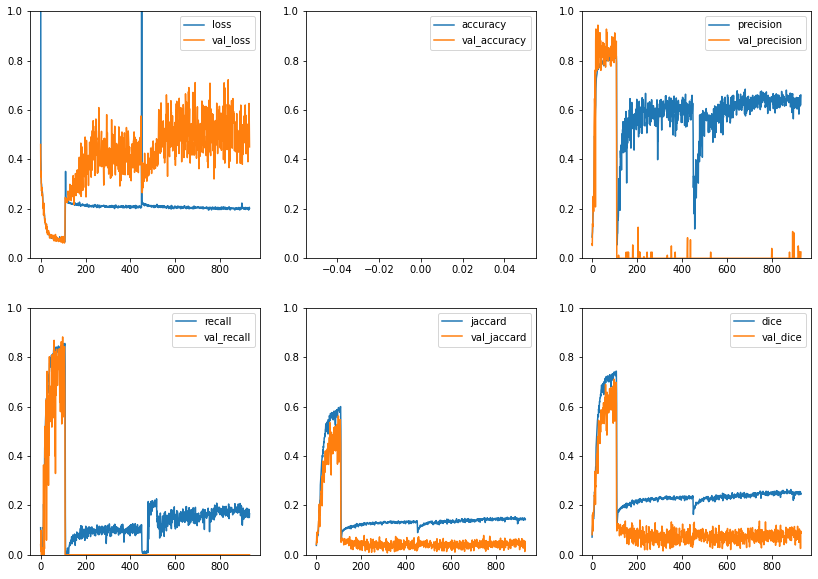

iteration 931
loss 0.20232784748077393 loss_val 0.4507024884223938
acc None acc_val None
prec 0.6601719856262207 prec_val 0.02499999664723873
rec 0.16621780395507812 rec_val 3.260642529312463e-07
jaccard 0.1422954797744751 jaccard_val 0.048610832542181015
dice 0.24610967934131622 dice_val 0.08747424930334091
time per epoch: 12.464380495530323
Epoch 932/1000
  5/100 [>.............................] - ETA: 6s - loss: 0.1975 - accuracy: 0.9218 - iou: 0.1641 - iou_thresholded: 0.1700 - keras_precision: 0.6875 - keras_recall: 0.1901 - keras_jaccard_coef: 0.1581 - keras_dice_coef: 0.2705
Epoch 00932: saving model to /raid/mpsych/RISTERLAB/fly_segmentation_experiments/classified_images/models/04-08/04-08-4-500-932-0.20.hdf5
 10/100 [==>...........................] - ETA: 8s - loss: 0.1945 - accuracy: 0.9250 - iou: 0.1586 - iou_thresholded: 0.1629 - keras_precision: 0.7476 - keras_recall: 0.1779 - keras_jaccard_coef: 0.1525 - keras_dice_coef: 0.2608batch 10 of 100 ...

Epoch 00932: saving mode

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [32]:
import keras.optimizers
from keras_unet.metrics import iou, iou_thresholded
from keras_unet.losses import jaccard_distance
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping

model = custom_unet(
    input_shape=(512, 512, 1),
    use_batch_norm=False,
    num_classes=1,
    filters=32,
    dropout=0.5,
    output_activation='sigmoid')

filepath = (os.path.join(MODELPATH, '04-08-4-1000-{epoch:02d}-{val_loss:.4f}-{loss:.2f}-{accuracy:.4f}.hdf5'))

checkpoint = ModelCheckpoint(filepath,
                             monitor='val_loss', 
                             verbose=1,
                             save_best_only=False,
                             mode='auto', 
                             period=1)


model.compile(optimizer = 'Adam',    
              loss='binary_crossentropy', 
              metrics = ['accuracy',iou, iou_thresholded,
                         keras_precision,
                         keras_recall,
                         keras_jaccard_coef,
                         keras_dice_coef])

# history = model.fit(X_train, 
#                     y_train, 
#                     32, 
#                     epochs=300,
#                     validation_data=(X_val, y_val), 
#                     verbose=1,
#                     callbacks=[checkpoint])
              

perform_standardization = False
perform_centering = False
perform_flipping = True
perform_rotation = True
plot_graph = True
train_on_borders = False

print('-------------------------------')
print('data details:')

print('imgs_train.shape', imgs_train.shape)
print('imgs_mask_train.shape', imgs_mask_train.shape)
print('imgs_test.shape', imgs_test.shape)
print('imgs_mask_test.shape', imgs_mask_test.shape)
print('imgs_train.dtype', imgs_train.dtype)
print('imgs_mask_train.dtype', imgs_mask_train.dtype)
print('imgs_test.dtype', imgs_test.dtype)
print('imgs_mask_test.dtype', imgs_mask_test.dtype)

print('balance:')
totalpx = (imgs_mask_train.shape[0]*imgs_mask_train.shape[1]*imgs_mask_train.shape[2])
marked = np.sum(imgs_mask_train>0.5)
print('train_total_px', totalpx)
print('train_labeled_positive', marked)
resag = marked/float(totalpx)
print('train_fraction_positive', resag)
print('min, max train', imgs_train.min(), imgs_train.max())
print('train_total_px', totalpx, 'number 0/1 in mask', np.sum(imgs_mask_train==0)+np.sum(imgs_mask_train==1))

totalpx_test = (imgs_mask_test.shape[0]*imgs_mask_test.shape[1]*imgs_mask_test.shape[2])
marked_test = np.sum(imgs_mask_test>0.5)
print('test_total_px', totalpx_test)
print('test_labeled_positive', marked_test)
resag_test = marked_test/float(totalpx_test)
print('test_fraction_positive', resag_test)        
print('min, max test', imgs_test.min(), imgs_test.max())

print("loading data done")

if not os.path.isdir(MODELPATH):
    os.mkdir(MODELPATH)

sname = MODELPATH + '04-08-4-500-{epoch:02d}-{loss:.2f}.hdf5'
model_checkpoint = ModelCheckpoint(sname, monitor='val_loss',verbose=1, save_best_only=False, save_freq=5)
print('saving model checkpoints in', MODELPATH)

logfile_path = MODELPATH + 'log.txt'
lcallbacks = [InteractivePlot(logfile_path, plot_graph, 100), model_checkpoint]
print('saving logfile in ', str(logfile_path))


data_gen_args = dict()
data_val_gen_args = dict()
print('augmenting on the fly...')
print('computing statistics...')
train_mean =None
train_sd = None

if perform_standardization:
    print('will standardize!')
    train_mean = np.mean(imgs_train, axis=0)
    train_sd = np.std(imgs_train, axis=0)
elif perform_centering:
    print('will center!')
    train_mean = np.mean(imgs_train, axis=0)

def cus_raw(img):
    return custom_preproc(img, 'raw', flip_z=perform_flipping, rotate=perform_rotation, mean=train_mean, sd=train_sd, train_on_borders=train_on_borders)

def cus_mask(img):
    return custom_preproc(img, 'mask', flip_z=perform_flipping, rotate=perform_rotation, mean=train_mean, sd=train_sd, train_on_borders=train_on_borders)

seed = 1

#setting up train generator
data_gen_args = dict(num_channels = MEMORY,
                     featurewise_center=False,
                     featurewise_std_normalization=False,               
                     samplewise_center=False, 
                     samplewise_std_normalization=False,
                     #rotation_range=180.,
                     #width_shift_range=0.05, 
                     #height_shift_range=0.05, 
                     #channel_shift_range=0.05,
                     #fill_mode='constant', cval=0,
                     preprocessing_function = cus_raw,               
                     horizontal_flip=perform_flipping,
                     vertical_flip=perform_flipping)

datagen = ExtImageDataGenerator(**data_gen_args) 

data_gen_args_mask = data_gen_args.copy()
data_gen_args_mask['num_channels'] = 1 
data_gen_args_mask['preprocessing_function'] = cus_mask 
data_gen_args_mask['featurewise_center'] = False
data_gen_args_mask['featurewise_std_normalization'] = False
data_gen_args_mask['samplewise_center'] = False
data_gen_args_mask['samplewise_std_normalization'] = False
datagen_mask = ExtImageDataGenerator(**data_gen_args_mask)

datagen.fit(imgs_train, augment=False, seed=seed)
datagen_mask.fit(imgs_mask_train, augment=False, seed=seed)


train_dir = None
test_dir = None
train_pref = None
test_pref = None
to_dir = False
bt_size = 4
iter_per_epoch = 100
train_epochs = 1000
val_steps = 40
verbosity = 1

if to_dir:
    train_dir = 'a'
    test_dir = 'b'
    train_pref = 'img'
    test_pref = 'img'
    print('saving augmented images!')
datagen = datagen.flow(imgs_train, batch_size=bt_size,shuffle=True, seed=seed, save_to_dir=train_dir, save_prefix=train_pref)
datagen_mask = datagen_mask.flow(imgs_mask_train, batch_size=bt_size, shuffle=True,seed=seed, save_to_dir=test_dir, save_prefix=test_pref)

def combine_generator(gen1, gen2):
    while True:
        yield(next(gen1), next(gen2))

train_generator = combine_generator(datagen, datagen_mask)#zip(datagen, datagen_mask)

#setting up validation generator
data_val_gen_args = dict(num_channels = MEMORY,
                         featurewise_center=False,
                         featurewise_std_normalization=False,
                         preprocessing_function = cus_raw,
                         samplewise_center=False,
                         samplewise_std_normalization=False)

datagen_val = ExtImageDataGenerator(**data_val_gen_args)

data_val_gen_args_mask = data_val_gen_args.copy()
data_val_gen_args_mask['num_channels'] = 1 
data_val_gen_args_mask['preprocessing_function'] = cus_mask 
data_val_gen_args_mask['featurewise_center'] = False
data_val_gen_args_mask['featurewise_std_normalization'] = False
data_val_gen_args_mask['samplewise_center'] = False
data_val_gen_args_mask['samplewise_std_normalization'] = False
datagen_val_mask = ExtImageDataGenerator(**data_val_gen_args_mask)

datagen_val.fit(imgs_train, augment=False, seed=seed) #fit to train, to substract training and not test mean
datagen_val_mask.fit(imgs_mask_train, augment=False, seed=seed)

datagen_val = datagen_val.flow(imgs_test, batch_size=bt_size, shuffle=True, seed=seed)
datagen_val_mask = datagen_val_mask.flow(imgs_mask_test, batch_size=bt_size, shuffle=True, seed=seed)

test_generator = combine_generator(datagen_val, datagen_val_mask)#zip(datagen_val, datagen_val_mask)

print(train_generator)
model.fit_generator(train_generator,
                         steps_per_epoch=iter_per_epoch, epochs=train_epochs, 
                         validation_data=test_generator,
                         validation_steps=val_steps, callbacks=lcallbacks, verbose=verbosity)              



In [33]:
model

In [34]:
pred = model.predict(imgs_test)

In [35]:
pred_file = os.path.join(NPYPATH, '4-8-pred.npy')

np.save(pred_file, pred)

In [36]:
pred.shape

(150, 512, 512, 1)

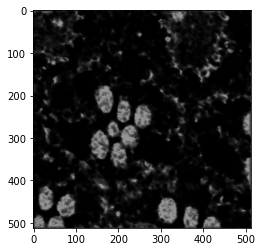

In [68]:
imshow(pred[130,:,:,0]*255, cmap='gray')

In [75]:
pred_img = pred[100,:,:,0]

In [76]:
print(pred_img.min(), pred_img.max())

5.4217026e-09 0.62601113


In [77]:
pred_img[pred_img <= 0.5] = 0
pred_img[pred_img > 0.5] = 1

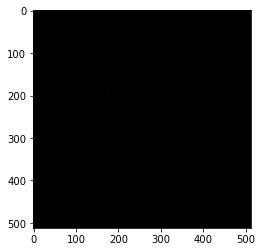

In [78]:
imshow(pred_img, cmap='gray')

In [46]:
def confusion_matrix(pred, gt, thres=0.5):
    TP = np.sum((gt==1) & (pred>thres))
    FP = np.sum((gt==0) & (pred>thres))
    TN = np.sum((gt==0) & (pred<=thres))
    FN = np.sum((gt==1) & (pred<=thres))
    return (TP, FP, TN, FN)

def statistics(cmatrix):
    TP,FP,TN,FN = cmatrix
    jaccard_foreground = TP/(TP+FP+FN)
    jaccard_background = TN/(TN+FP+FN)
    VOC_score = (jaccard_foreground+jaccard_background)/2.
    accuracy = (TP+TN)/(TP+FP+TN+FN)
    precision = TP/(TP+FP)
    recall = TP/(TP+FN)
    return {'jaccard_foreground': jaccard_foreground, 'jaccard_background': jaccard_background, 
            'voc_score': VOC_score, 'accuracy': accuracy, 'precision': precision, 'recall': recall}
    
def PR_curve(pred, gt):
    test_mask_in = gt.copy().astype(np.byte)
    precs, recs, thres = precision_recall_curve(test_mask_in.flatten(), pred.flatten(), pos_label=1)

    res = plt.figure(figsize=(7,7))
    res = plt.title('AUC = ' + str(auc(recs,precs)))
    res = plt.plot(recs, precs, color='orange')
    res = plt.xlabel('recall')
    res = plt.ylabel('precision')
    res = plt.xlim(0,1)
    res = plt.ylim(0,1)    
    
def error_distribution(model, test_in, test_mask_in, stepsize=512, resize=True, extensive=False, figsize=(10,8)):
    pred = model.predict(test_in)
    pred = improve_components(pred)
    pred[pred>0.5] = 1
    pred[pred<=0.5] = 0
        
    fp = np.sum((test_mask_in==0) & (pred==1), axis=0)[:,:,0]
    fn = np.sum((test_mask_in==1) & (pred==0), axis=0)[:,:,0]
    
    plt.figure(figsize=figsize)
    plt.imshow(fp)
    plt.title('distribution of errors, fp')
    plt.colorbar()
   
    plt.figure(figsize=figsize)
    plt.imshow(fn)
    plt.title('distribution of errors, fn')
    plt.colorbar()

    plt.figure(figsize=figsize, dpi=300)
    plt.imshow(fn+fp)
    plt.title('distribution of errors, overall')
    plt.colorbar()
    plt.savefig('output.png', format='png', bbox_inches='tight')
    
    if extensive:
        print('extensive analysis...')
        desc = ['width', 'height', 'stack']
        axis_analyze = [(0,1,3),(0,2,3),(1,2,3)]
        
        for i in range(len(desc)):
            axis = axis_analyze[i]
            tp_col = np.sum((test_mask_in==1) & (pred==1), axis=axis)
            fp_col = np.sum((test_mask_in==0) & (pred==1), axis=axis)
            fn_col = np.sum((test_mask_in==1) & (pred==0), axis=axis)
            normalizer = (tp_col+fp_col+fn_col)
            normalizer[normalizer==0] = 1e7
            vals = tp_col/normalizer.astype(float)
            plt.figure(figsize=figsize)
            plt.title('jaccard index across ' + desc[i] + ', mean=' + str(np.mean(vals))) 
            plt.plot(range(len(vals)), vals)
            plt.show()

In [42]:
cmatrix = confusion_matrix(pred, imgs_mask_test)

In [43]:
statistics(cmatrix)

{'jaccard_foreground': 9.805382762921534e-07,
 'jaccard_background': 0.8962557877864368,
 'voc_score': 0.4481283841623565,
 'accuracy': 0.8962557983398437,
 'precision': 0.10526315789473684,
 'recall': 9.80546448730413e-07}

In [48]:
def improve_components(test_pred, depth=9):
    return median_filter(test_pred, size=(depth,1,1,1)) #run z-smoothing (median filter)

extensive analysis...


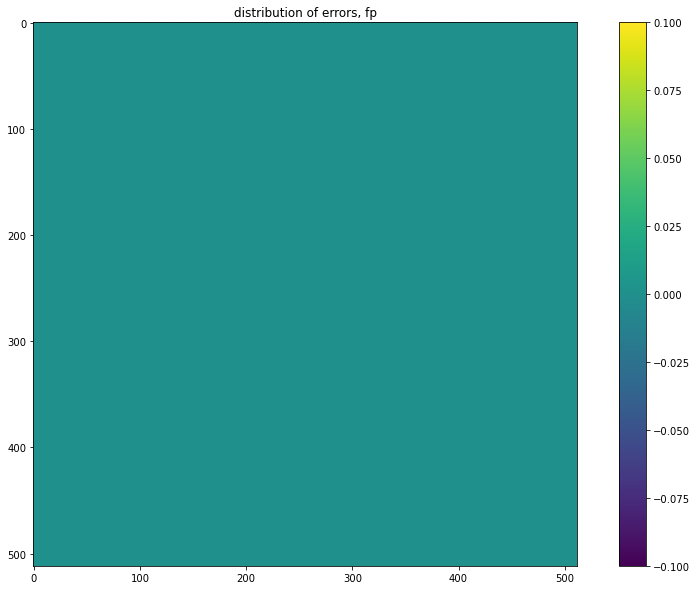

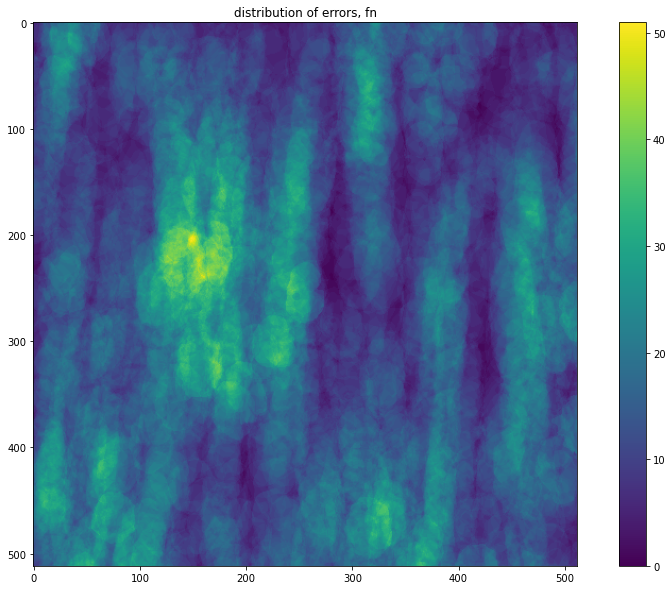

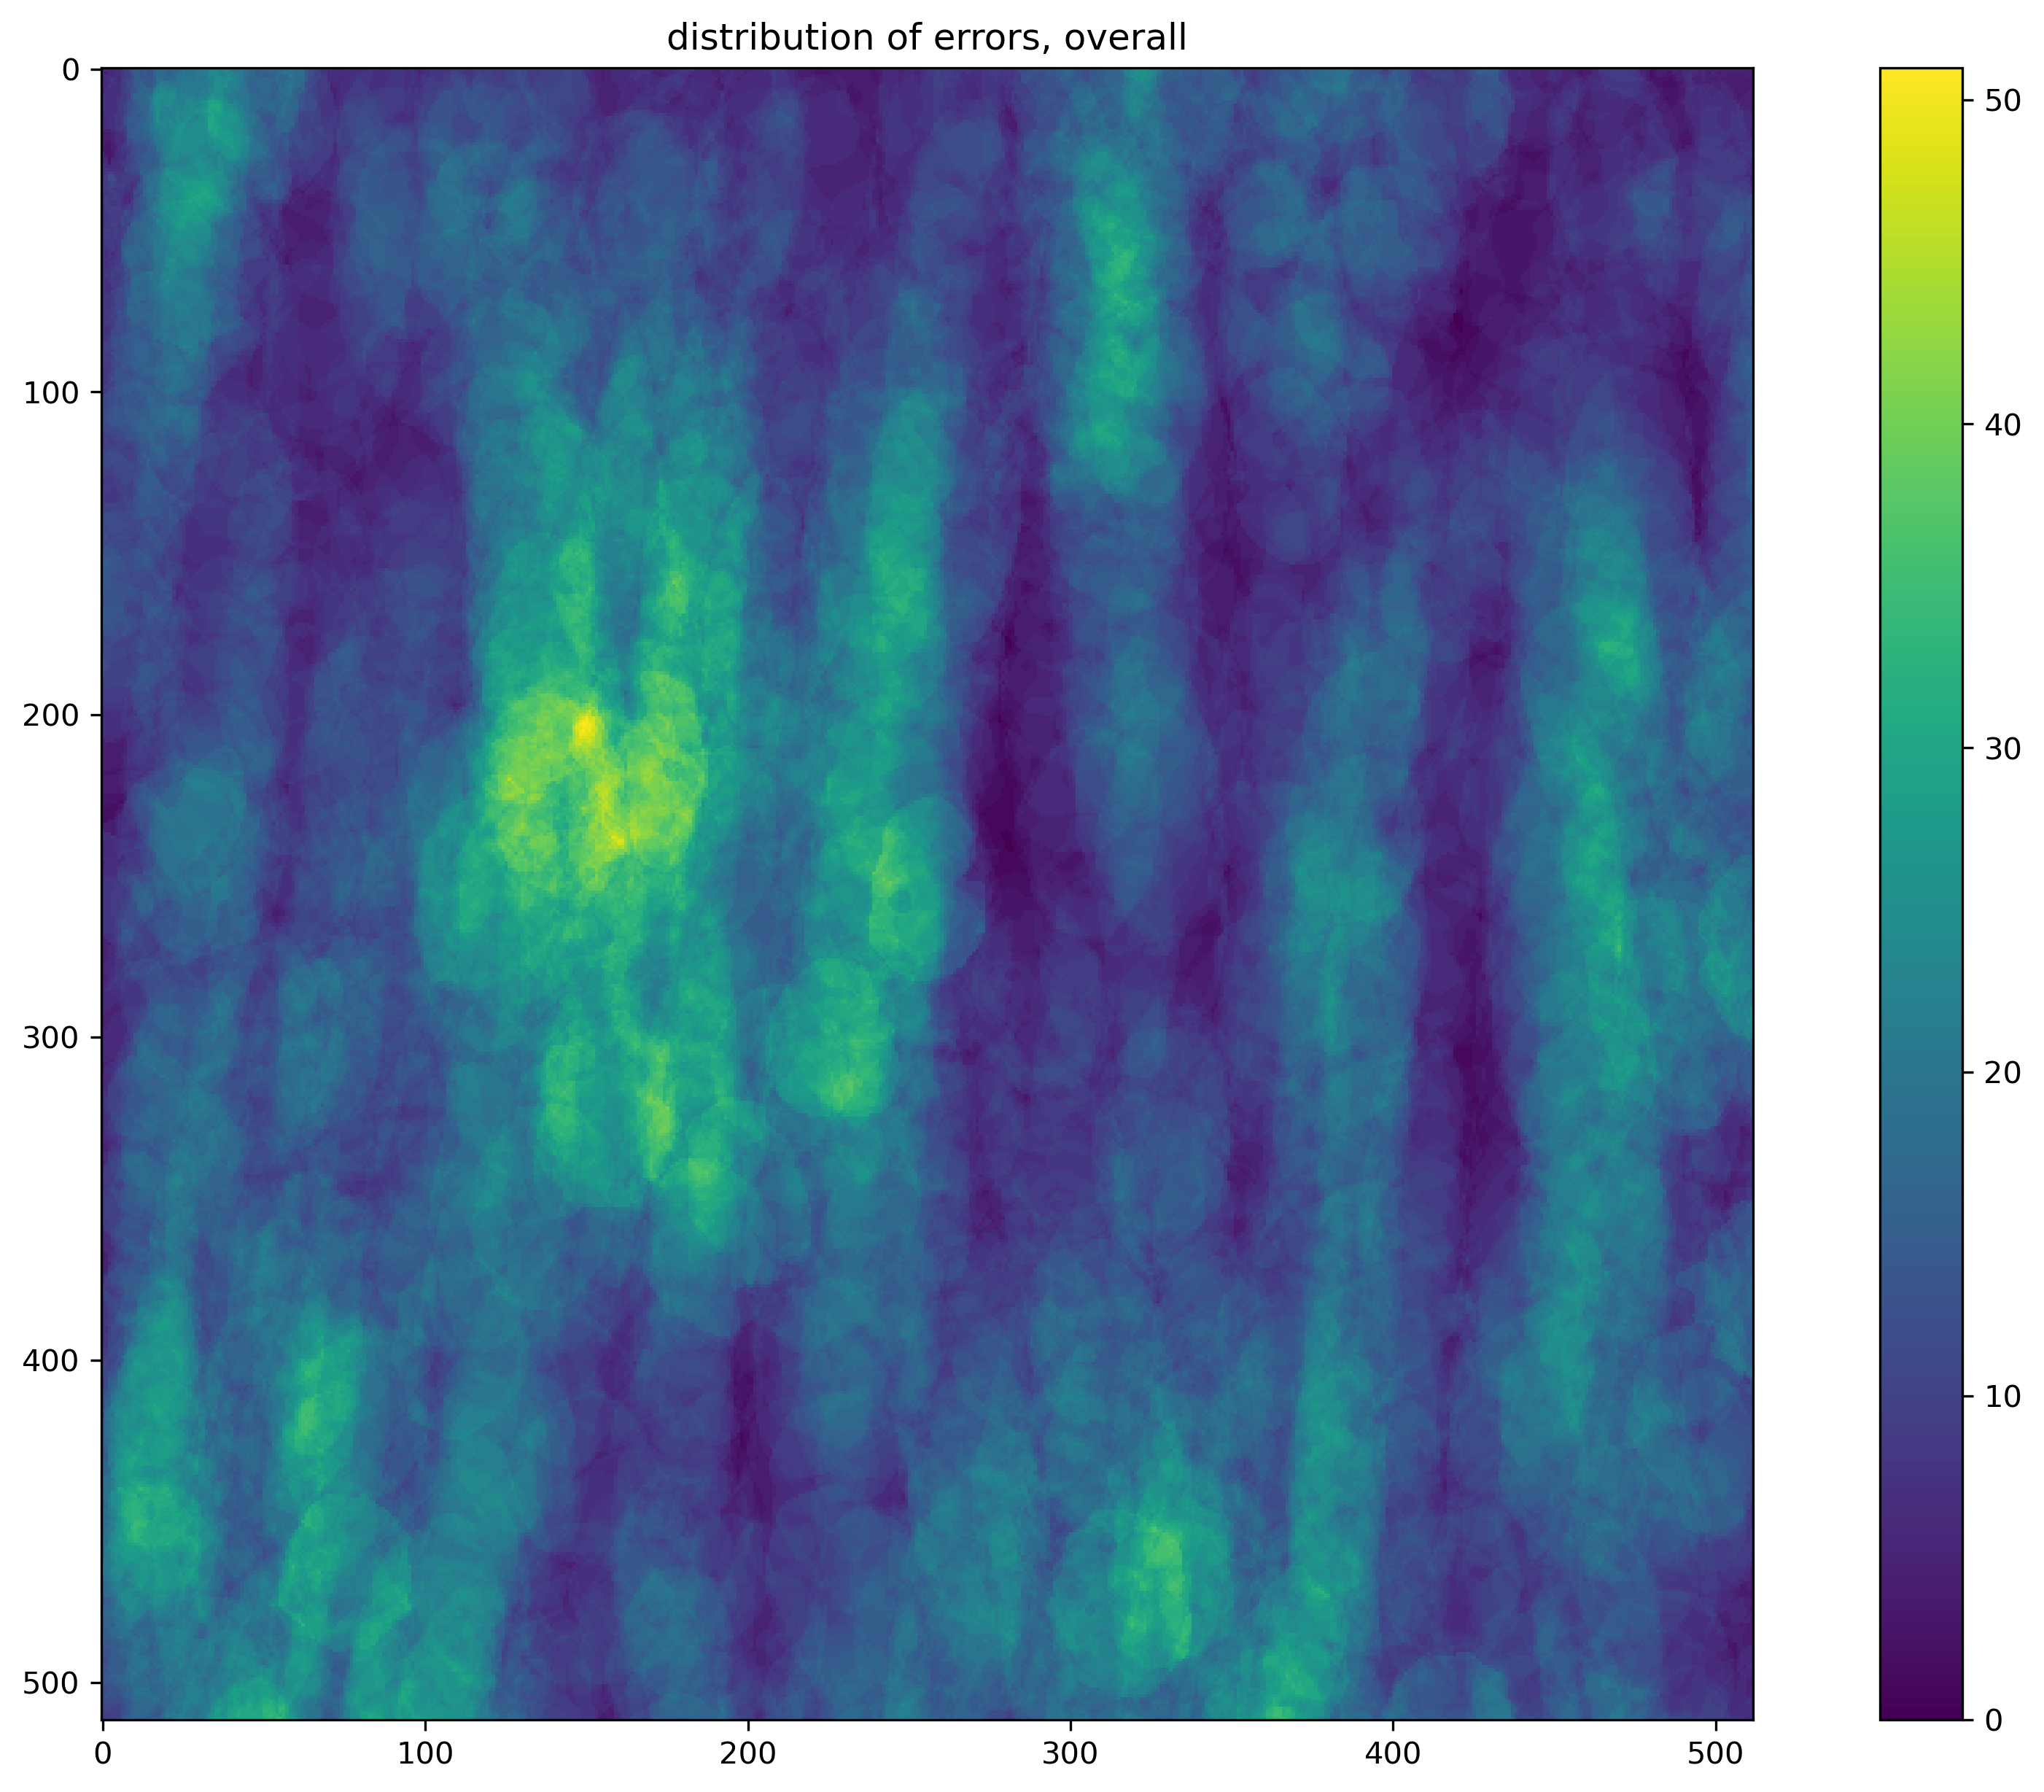

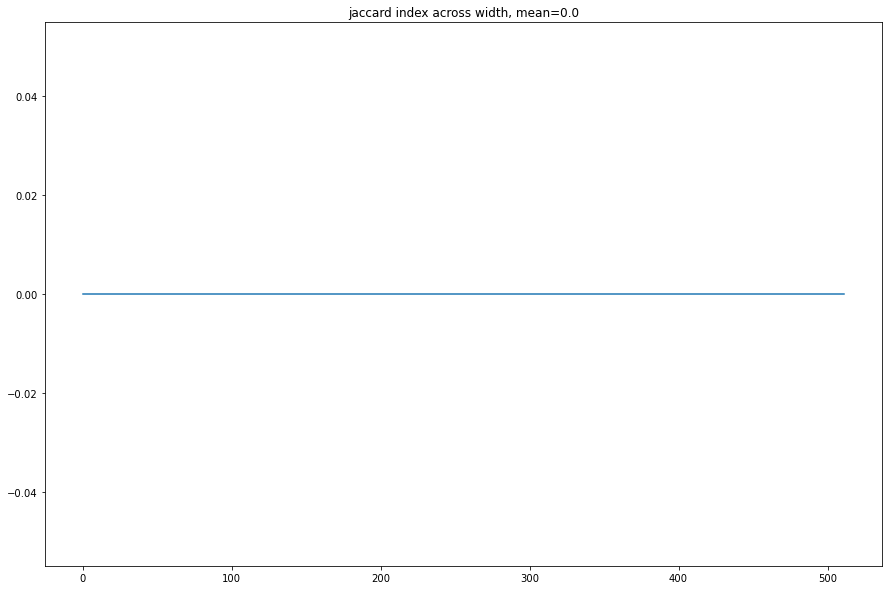

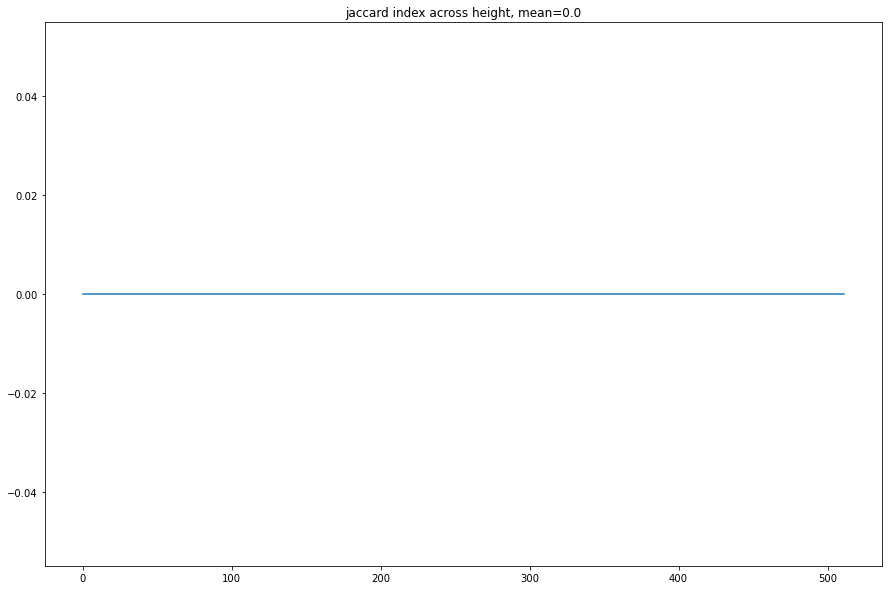

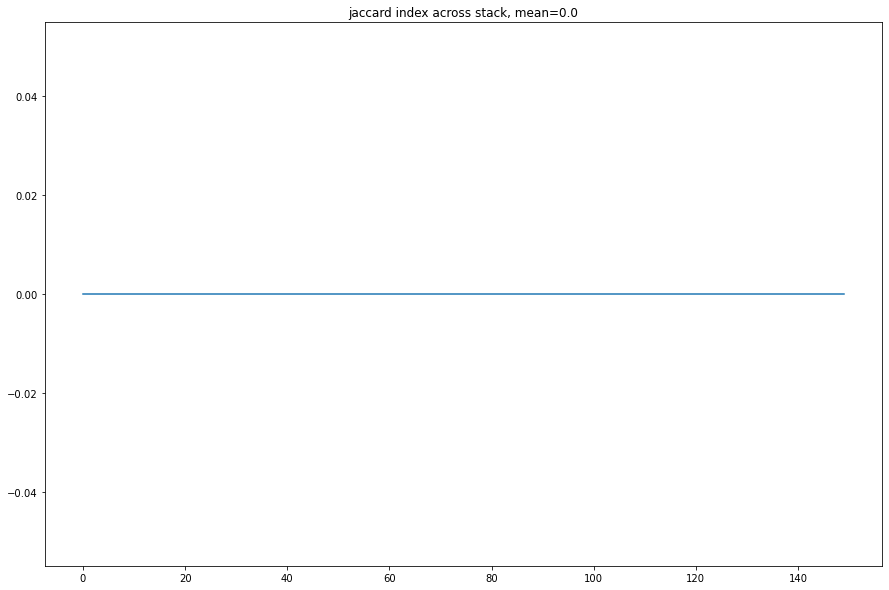

In [49]:
error_distribution(model, imgs_test, imgs_mask_test, extensive=True, figsize=(15,10))

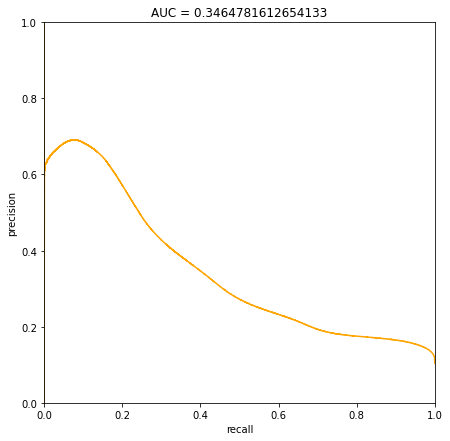

In [50]:
PR_curve(pred, imgs_mask_test)